In [1]:
# !conda create --name steffen-voxelmorph-python3.7_tf2.4.1 python=3.7 tensorflow-gpu=2.4.1
# !pip install voxelmorph  # for all things voxelmorph/neurite
# !pip install tensorflow_addons  # for tqdm callbacks

# some imports we'll need throughout the demo
import os

# some third party very useful libraries
import tensorflow as tf
import tensorflow_addons as tfa  # for TQDM callback
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import nibabel as nib

# our libraries
import voxelmorph as vxm
import neurite as ne

# turn off eager for this
# need to do it due to some tf 2.0+ compatibility issues
tf.compat.v1.disable_eager_execution()

# some helpful functions
def plot_hist(hist):
  plt.figure(figsize=(17,5))
  plt.subplot(1, 2, 1)
  plt.plot(hist.epoch, hist.history['loss'], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.subplot(1, 2, 2)
  nb_epochs = len(hist.epoch) // 2
  plt.plot(hist.epoch[-nb_epochs:], hist.history['loss'][-nb_epochs:], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.show()


# generally useful callback
# unfortunately show_epoch_progress=True leaves a printout that we can't control (bad implementation in tfa...)
tqdm_cb = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False, show_epoch_progress=False) 

In [3]:
# get the data
![ ! -f data-3d.tar ] && wget http://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.v1.0.tar -O  data-3d.tar
![ ! -d oasis-data-3d ] && mkdir oasis-data-3d && tar -xf data-3d.tar --directory oasis-data-3d

--2021-07-26 07:26:54--  http://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.v1.0.tar
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.240.105
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.240.105|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.v1.0.tar [following]
--2021-07-26 07:26:54--  https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.v1.0.tar
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.240.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7006289920 (6.5G) [application/x-tar]
Saving to: ‘data-3d.tar’

100%[====================================>] 7,006,289,920 16.7MB/s   in 6m 47s 

2021-07-26 07:33:42 (16.4 MB/s) - ‘data-3d.tar’ saved [7006289920/7006289920]



In [4]:
# prepare data
files = ['oasis-data-3d/' + f + '/' + 'aligned_norm.nii.gz' for f in os.listdir('oasis-data-3d') if f.startswith('OASIS_OAS1_')]
vols = [nib.load(f).get_fdata() for f in tqdm(files)]
x_vols = np.stack(vols, 0)
vol_shape = x_vols.shape[1:-1]

/home/opc/miniconda3/envs/steffen-voxelmorph-python3.7_tf2.4.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/414 [00:00<?, ?it/s]

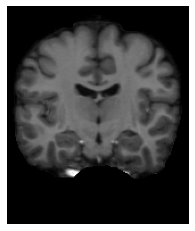

In [5]:
# visualize input data
example=x_vols[7,:,:,0]
plt.imshow(np.rot90(example, -1), cmap='gray')
plt.axis('off');

In [6]:
# get the model
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]
model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])

LocalParamWithInput: Consider using neuron.layers.LocalParam()
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow 

In [7]:
# prepare a simple generator. 
def template_gen(x, batch_size):
  vol_shape = list(x.shape[1:-1])
  zero = np.zeros([batch_size] + vol_shape + [2])
  mean_atlas = np.repeat(  np.mean(x, 0, keepdims=True), batch_size, 0)

  while True:
    idx = np.random.randint(0, x.shape[0], batch_size)
    img = x[idx, ...]
    inputs = [mean_atlas, img]
    outputs = [img, zero, zero, zero]
    yield inputs, outputs


In [8]:
# let's make sure the sizes make sense
sample = next(template_gen(x_vols, 8))
[f.shape for f in sample[0]], [f.shape for f in sample[1]]

enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

vol_shape

model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])

LocalParamWithInput: Consider using neuron.layers.LocalParam()


In [9]:
# prepare losses
image_loss_func = vxm.losses.MSE().loss
neg_loss_func = lambda _, y_pred: image_loss_func(model.references.atlas_tensor, y_pred)
losses = [image_loss_func, neg_loss_func, vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=2).loss]
loss_weights = [0.5, 0.5, 1, 0.01]

model.compile('adam', loss=losses, loss_weights=loss_weights)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [10]:
# train
gen = template_gen(x_vols, batch_size=2)
hist = model.fit(gen, epochs=10, steps_per_epoch=25, verbose=0, callbacks=[tqdm_cb])

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

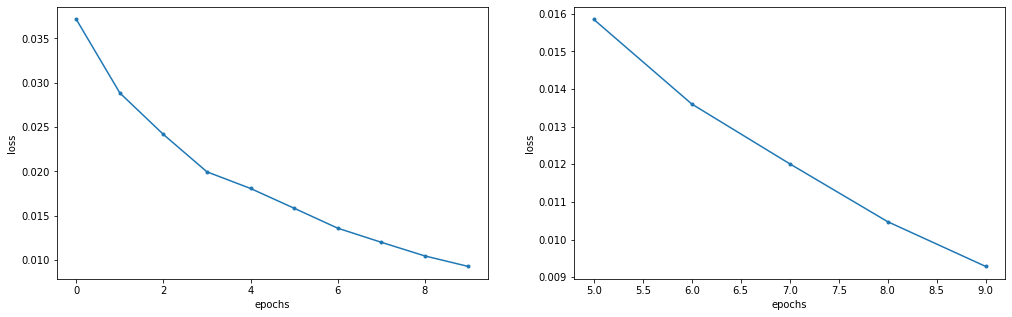

In [ ]:
# visualize optimization
plot_hist(hist)

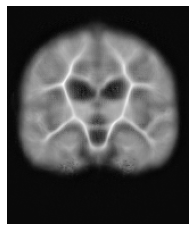

In [ ]:
atlas = model.references.atlas_layer.get_weights()[0][..., 0]
plt.imshow(np.rot90(atlas, -1), cmap='gray')
plt.axis('off');